# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 64
T = Float64;

In [5]:
prob = load_cmb_lensing_problem(;storage=Array, T, Nside, masking=true)
Cuprob = load_cmb_lensing_problem(;storage=CuArray, T, Nside, masking=true);

In [6]:
prob.Λmass.diag.θ.r *= 5.85
prob.Λmass.diag.θ.Aϕ *= 112.09

112.09

# MCHMC

In [17]:
function get_mask_distance(prob)
    prob.ds.M isa LazyBinaryOp || error("masking must be enabled")
    mx = diag(prob.ds.M[2])[:Qx] .== 1;
    nearest = getfield.(@eval(CMBLensing,@ondemand(ImageMorphology.feature_transform))(mx), :I)
    Ny, Nx = size(mx)
    return [norm(nearest[i,j] .- [i,j]) for i=1:Ny,j=1:Nx]
end

get_mask_distance (generic function with 1 method)

In [18]:
dist_mat = get_mask_distance(prob)
dist_matt = exp.(-1.0 .* dist_mat)
threshold = 0.25
dist_matt[dist_matt .< threshold] .= threshold;

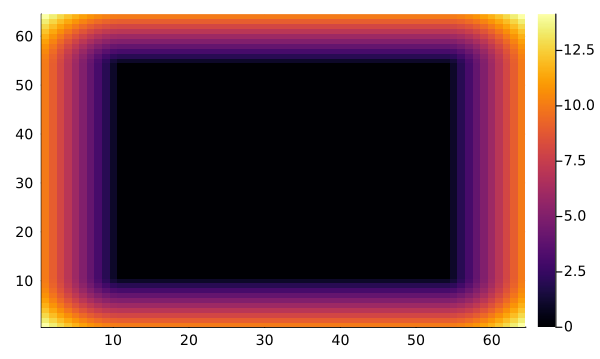

In [19]:
heatmap(dist_mat)

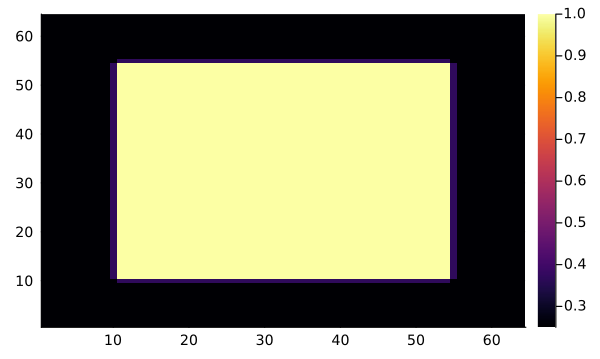

In [20]:
heatmap(dist_matt)

In [37]:
dist_mat_precond = adapt(CuArray, [vec(dist_matt); vec(dist_matt); ones(64*64+2)]);

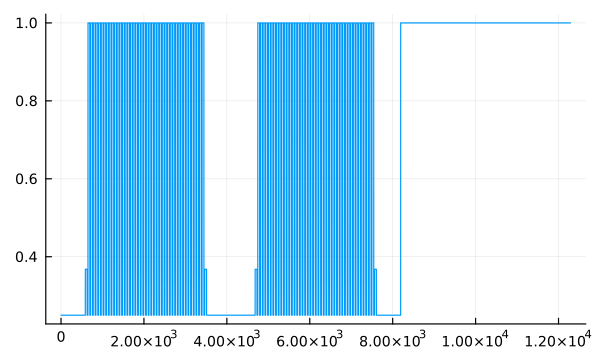

In [38]:
plot(dist_mat_precond, label=nothing)

## Init

In [39]:
target = CMBLensingTarget(Cuprob);

In [40]:
d = length(prob.Ωstart)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(Cuprob.Ωstart);

## Sample

In [41]:
precond = from_vec(dist_mat_precond);

In [45]:
TEV = 0.0001
spl = MCHMC(500, TEV; adaptive=true, init_eps=30, init_L=10.0*sqrt(50), sigma=from_vec(dist_mat_precond));

In [46]:
prob.ncalls[] = 0
samples_mchmc = adapt(Array, Sample(spl, target, 10_000, dialog=false, progress=true));
ncalls_mchmc = prob.ncalls[]

MCHMC:  77%|██████████████████████████████████          |  ETA: 0:02:48
  ϵ:     11.771892584322373
  dE/d:  7.960929037462026e-6

LoadError: InterruptException:

In [51]:
chain_mchmc = Chains(
    permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]); sample[end-3:end]] for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),
    [:r, :Aϕ, :p_logr, :p_logAϕ, :dE, :logpdf],
);

In [52]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
 56.14388086038932
 66.15545927402121

In [53]:
ess_per_call_mchmc = ess_mchmc / ncalls_mchmc

2-element Vector{Float64}:
 0.0013367590681045076
 0.0015751299827147908

## Plot

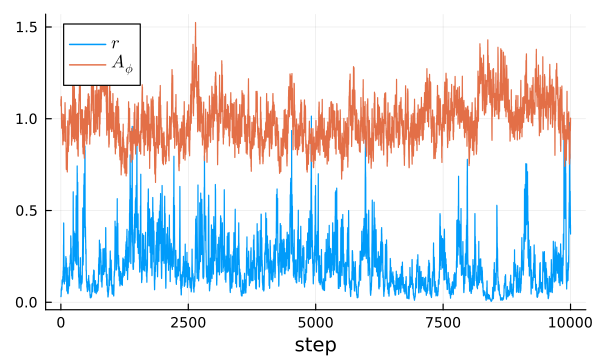

In [54]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(chain_mchmc[:Aϕ], label=L"A_\phi")

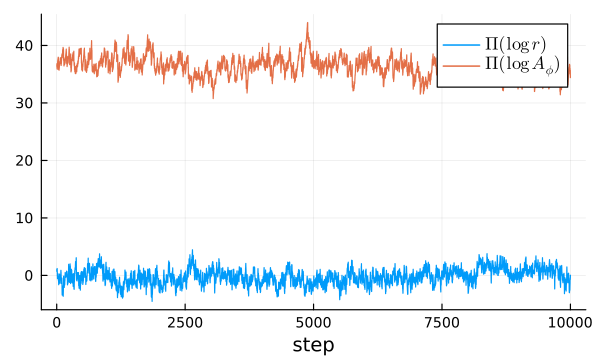

In [55]:
plot(chain_mchmc[:p_logr], label=L"\Pi(\log \, r)", xlabel="step")
plot!(chain_mchmc[:p_logAϕ], label=L"\Pi(\log \, A_\phi)")

In [56]:
std(chain_mchmc[:dE])^2/d

0.00010147012964567949

In [47]:
d

12290

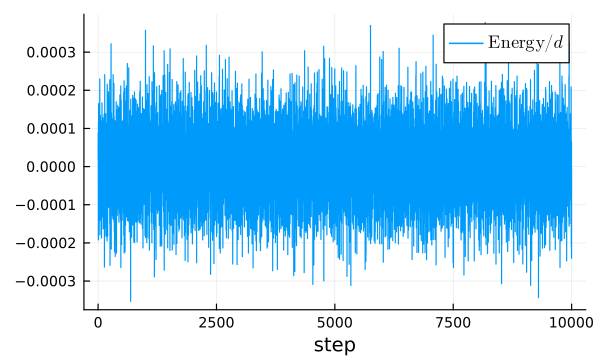

In [57]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

In [58]:
vars = var(samples_mchmc, dims=2)[1:d]
_vars = var(samples_mchmc, dims=2)[d+1:2*d]

12290-element Vector{Float64}:
 15.687510730785595
  9.725197756117876
  3.988755749486378
  1.713394951973242
  3.5885934415633995
  5.675130096250518
  5.092504963655049
  2.39960415531439
  2.1263542925174233
  5.6446364003717076
  1.642700871630958
  2.238048218989273
  2.4728109349155285
  ⋮
  1.2732272176520298
  1.323654539555007
  1.429404497019454
  1.284391560425181
  1.3125074336436007
  1.3022975614031096
  1.2557940969747483
  1.1100094148846629
  1.2065110543405846
  1.3549099629484882
  3.2570095272255806
  1.688138814616192

In [59]:
k = round(maximum(vars)/minimum(vars), digits=2)
_k = round(maximum(_vars)/minimum(_vars), digits=2)

41.94

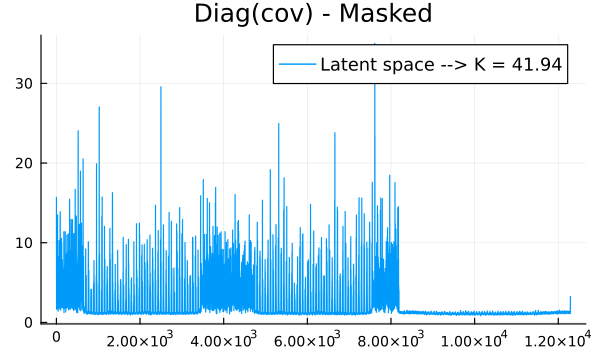

In [62]:
plot(_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _k))
#plot!(vars, label=string("Parameter space --> K = ", k))

In [64]:
using CMBLensing: fit, Histogram, Weights
_vars_q = _vars[1:Int((d-2)/3)]
_vars_u = _vars[Int((d-2)/3)+1:Int(2*(d-2)/3)];

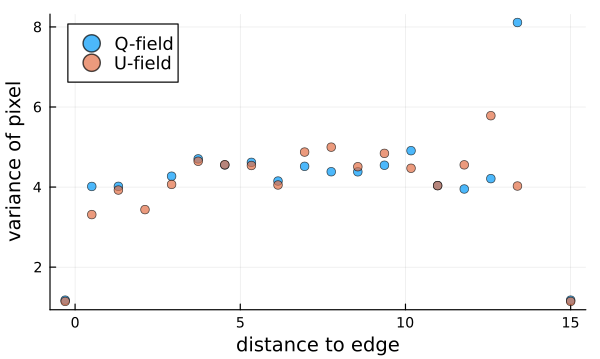

In [65]:
_edges = range(-0.3,15,length=20)
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_vars_q), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_vars_u), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
plot(_edges, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field", alpha=0.7)
plot!(_edges, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field", alpha=0.7)
     


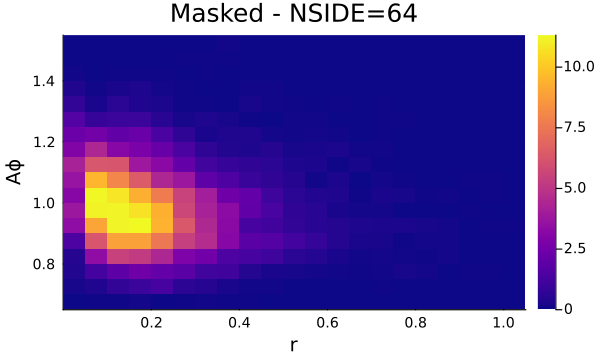

In [61]:
histogram2d(chain_mchmc[:r], chain_mchmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Masked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

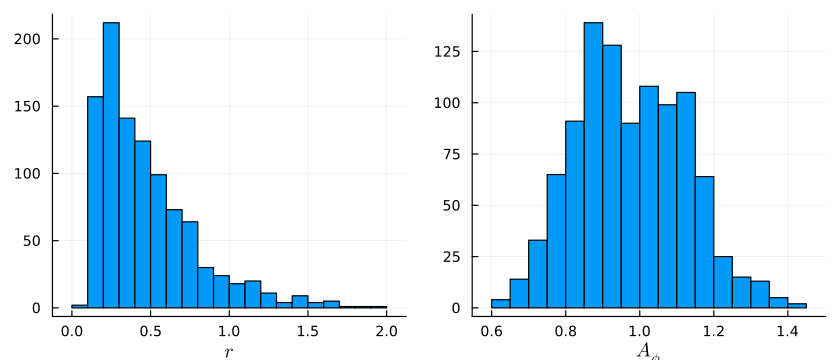

In [115]:
plot(
    histogram(chain_mchmc[:r], xlabel=L"r", label=nothing, lw=1),
    histogram(chain_mchmc[:Aϕ], xlabel=L"A_\phi", label=nothing, lw=1),
    size = (700,300)
)

### Animation

In [26]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples_mchmc[end][1:end-2]);

LoadError: MethodError: no method matching getindex(::Float64, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  getindex(::Union{Real, Field, FieldOp}, [91m::typeof(!)[39m, [91m::Any[39m)
[0m[90m   @[39m [35mCMBLensing[39m [90m~/.julia/packages/CMBLensing/ujQ46/src/[39m[90m[4mgeneric.jl:362[24m[39m
[0m  getindex(::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:95[24m[39m
[0m  getindex(::Union{AbstractChar, Number}, [91m::CartesianIndex{0}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmultidimensional.jl:853[24m[39m
[0m  ...


In [27]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

LoadError: UndefVarError: `last_sample` not defined

In [28]:
ϕs = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples_mchmc[end-500:end]]
anim = @animate for i in 1:length(ϕs)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(ϕs, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

LoadError: MethodError: no method matching getindex(::Float64, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  getindex(::Union{Real, Field, FieldOp}, [91m::typeof(!)[39m, [91m::Any[39m)
[0m[90m   @[39m [35mCMBLensing[39m [90m~/.julia/packages/CMBLensing/ujQ46/src/[39m[90m[4mgeneric.jl:362[24m[39m
[0m  getindex(::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:95[24m[39m
[0m  getindex(::Union{AbstractChar, Number}, [91m::CartesianIndex{0}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmultidimensional.jl:853[24m[39m
[0m  ...


In [29]:
mp4(anim, "kappa_samples.mp4", fps = 25)

LoadError: UndefVarError: `anim` not defined

# HMC

In [7]:
Ω = prob.Ωstart
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
@showprogress for i=1:500
    Ω, = state = hmc_step(rng, prob, Ω, prob.Λmass; symp_kwargs=[(N=25, ϵ=0.05)], progress=false, always_accept=(i<10))
    push!(samples_hmc, state)
end
ncalls_hmc = prob.ncalls[]

Progress: 100%|█████████████████████████████████████████| Time: 0:27:44


28000

In [8]:
_samples_hmc = zeros(500, 12290)
for i in 1:100
    _samples_hmc[i, :] = samples_hmc[i][1][:]
end

In [9]:
@save "../chains/HMC/CMBLensing_masked." _samples_hmc

In [10]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

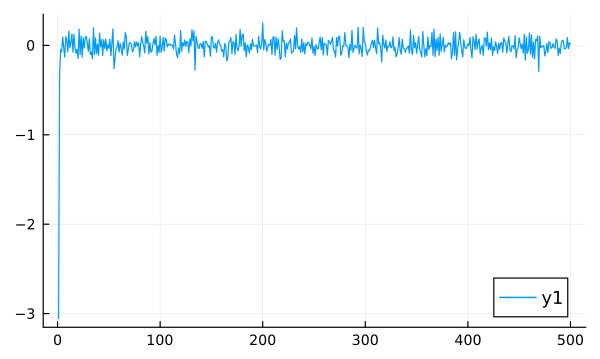

In [11]:
plot(getindex.(samples_hmc, 2))

## Plot

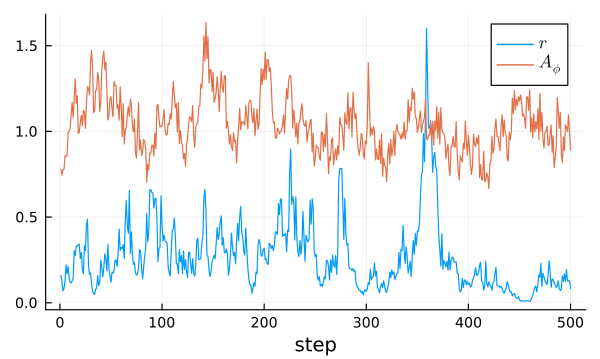

In [28]:
plot(chain_hmc[:r], label=L"r", xlabel="step")
plot!(chain_hmc[:Aϕ], label=L"A_\phi")

In [29]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
 5.816625964162885
 7.932540944243948

In [30]:
ess_per_call_hmc = ess_hmc ./ ncalls_hmc

2-element Vector{Float64}:
 0.0002077366415772459
 0.00028330503372299816

# MUSE

In [31]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [32]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [33]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseProblem, θ) = exp.(θ)

In [34]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [35]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

MUSE: 100%|█████████████████████████████████████████████| Time: 0:11:10
get_H: 100%|████████████████████████████████████████████| Time: 0:00:42


In [36]:
chain_muse = Chains(permutedims(rand(result.dist,1000000)), [:logr, :logAϕ]);

In [37]:
ess_per_call_muse = nsims / ncalls_muse

0.006596741209842338

## Plot

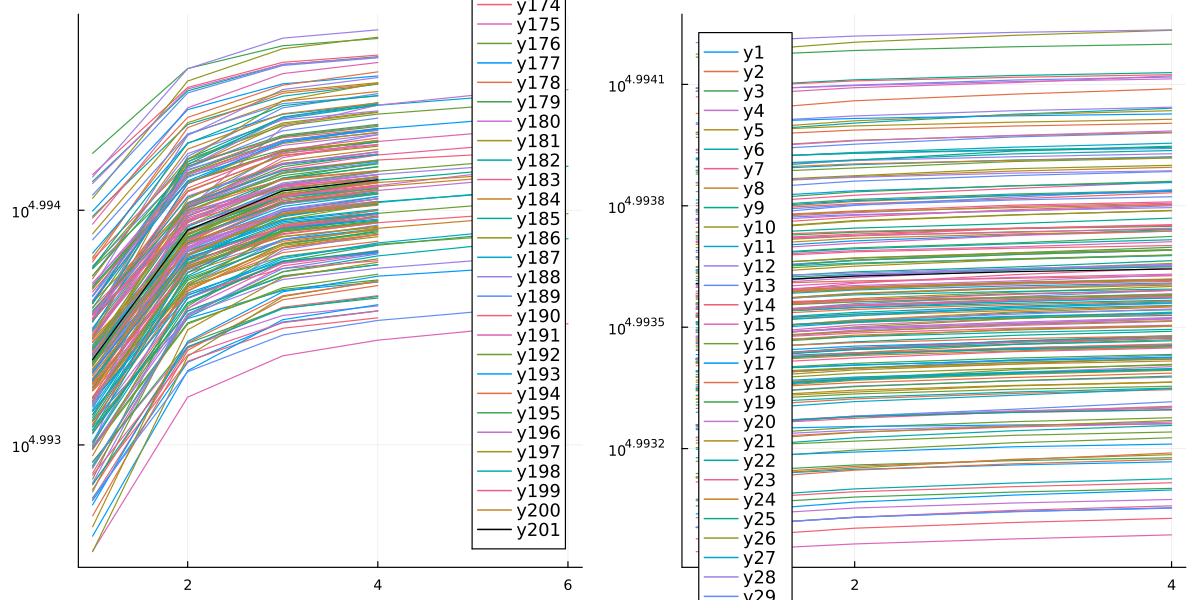

In [38]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(first.(x), yscale=:log10)
        end
        plot!(first.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    # ylim = (1e-7, 1e-3)
)

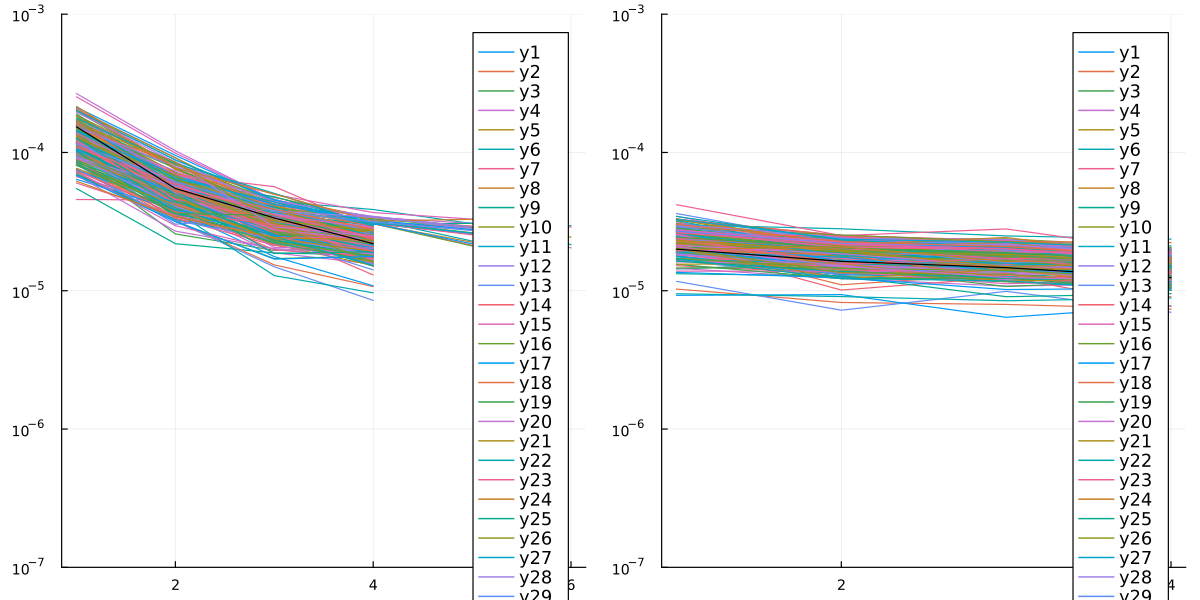

In [39]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(last.(x), yscale=:log10)
        end
        plot!(last.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    ylim = (1e-7, 1e-3)
)

┌ Warning: Skipped marker arg ..
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/args.jl:1147
┌ Warning: Skipped marker arg ..
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/args.jl:1147


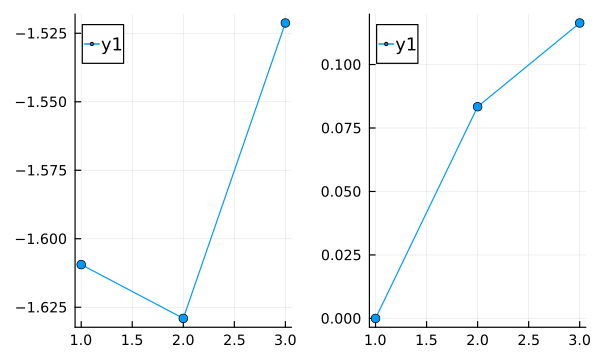

In [40]:
plot(
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :r), m="."),
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :Aϕ), m=".")
)

# Compare

In [49]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

31.755308836016635

In [50]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

7.149650035604122

In [51]:
ess_per_call_mchmc

2-element Vector{Float64}:
 0.0009226663091188539
 0.003801399872553483

In [52]:
ess_per_call_hmc

2-element Vector{Float64}:
 0.0002077366415772459
 0.00028330503372299816

In [53]:
ess_per_call_muse

0.006596741209842338

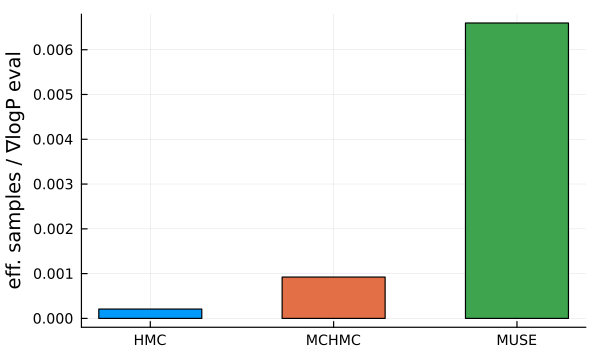

In [54]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

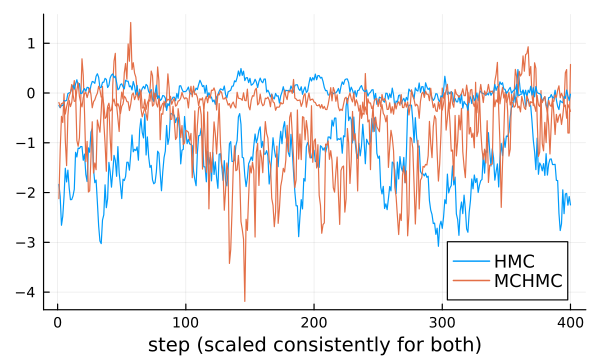

In [55]:
p = plot(label=L"r", xlabel="step (scaled consistently for both)")
for k in [:r, :Aϕ]
    plot!(log.(chain_hmc[k][1:length(chain_mchmc)÷25]), c=1, label=(k==:r ? "HMC" : nothing))
    plot!(log.(chain_mchmc[k][1:25:end]), c=2, label=(k==:r ? "MCHMC" : nothing))
end
p

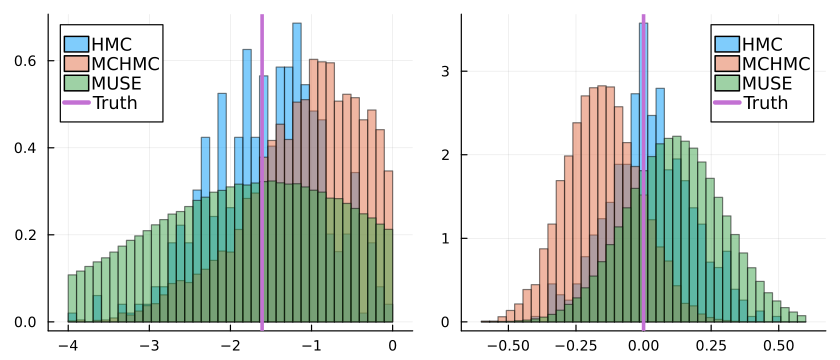

In [56]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)